<a href="https://colab.research.google.com/github/318281029SBH/Escuela/blob/main/GWeatherLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sm
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif
from sklearn.metrics import r2_score, make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Exploratory Analysis

In [4]:
df=pd.read_csv('/content/drive/MyDrive/dataSet/DWD.csv', sep=',', index_col=0 )

In [5]:
dwd=df.drop(['DWD_ID', 'STATION_NAME', 'FEDERAL_STATE', 'PERIOD'], axis=1)

In [6]:
dwd.loc[lambda dwd: dwd.isnull().any(axis=1)].shape

(395, 17)

In [7]:
miss=dwd.describe().T[['count']]/len(dwd) #establece la proporción de registros por columna respecto al total
areleft=miss.loc[miss['count']>.7]
dwd=dwd[[v for v in areleft.index]] # se eliminan las columnas con más del 70% de valores ausentes

##Data Visualization

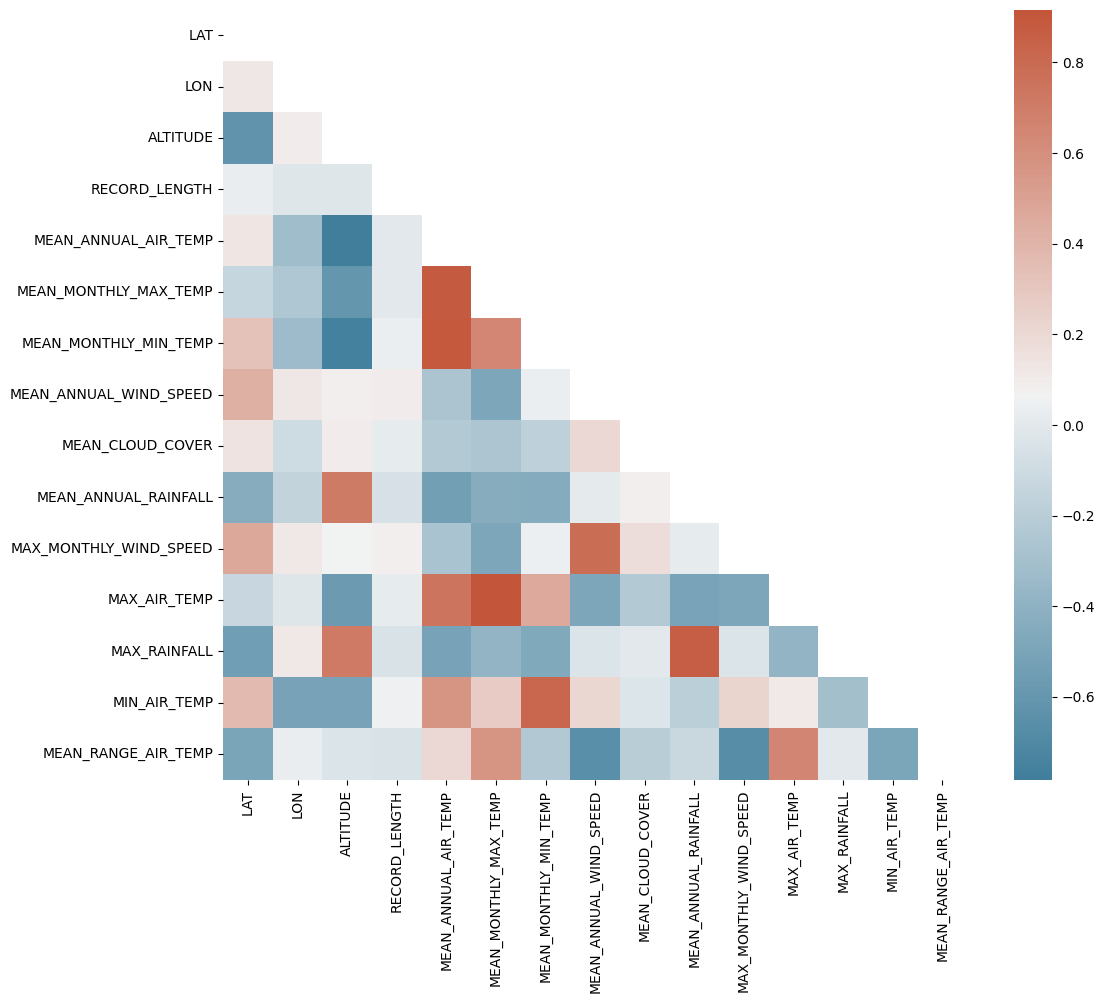

,MEAN_ANNUAL_RAINFALL
MEAN_ANNUAL_RAINFALL,1.000000
MAX_RAINFALL,0.863788
ALTITUDE,0.709002
MAX_AIR_TEMP,-0.509815
MEAN_ANNUAL_AIR_TEMP,-0.539133


In [8]:
#Pearson Correlation
corr = dwd.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=cmap)
plt.show()

#best features
corr.loc[corr.abs()['MEAN_ANNUAL_RAINFALL']>.5].filter(like='MEAN_ANNUAL_RAINFALL', axis=1).sort_values(by='MEAN_ANNUAL_RAINFALL', ascending=False)


array([[<Axes: title={'center': 'LAT'}>, <Axes: title={'center': 'LON'}>,
        <Axes: title={'center': 'ALTITUDE'}>,
        <Axes: title={'center': 'RECORD_LENGTH'}>],
       [<Axes: title={'center': 'MEAN_ANNUAL_AIR_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MAX_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MIN_TEMP'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_WIND_SPEED'}>],
       [<Axes: title={'center': 'MEAN_CLOUD_COVER'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_RAINFALL'}>,
        <Axes: title={'center': 'MAX_MONTHLY_WIND_SPEED'}>,
        <Axes: title={'center': 'MAX_AIR_TEMP'}>],
       [<Axes: title={'center': 'MAX_RAINFALL'}>,
        <Axes: title={'center': 'MIN_AIR_TEMP'}>,
        <Axes: title={'center': 'MEAN_RANGE_AIR_TEMP'}>, <Axes: >]],
      dtype=object)

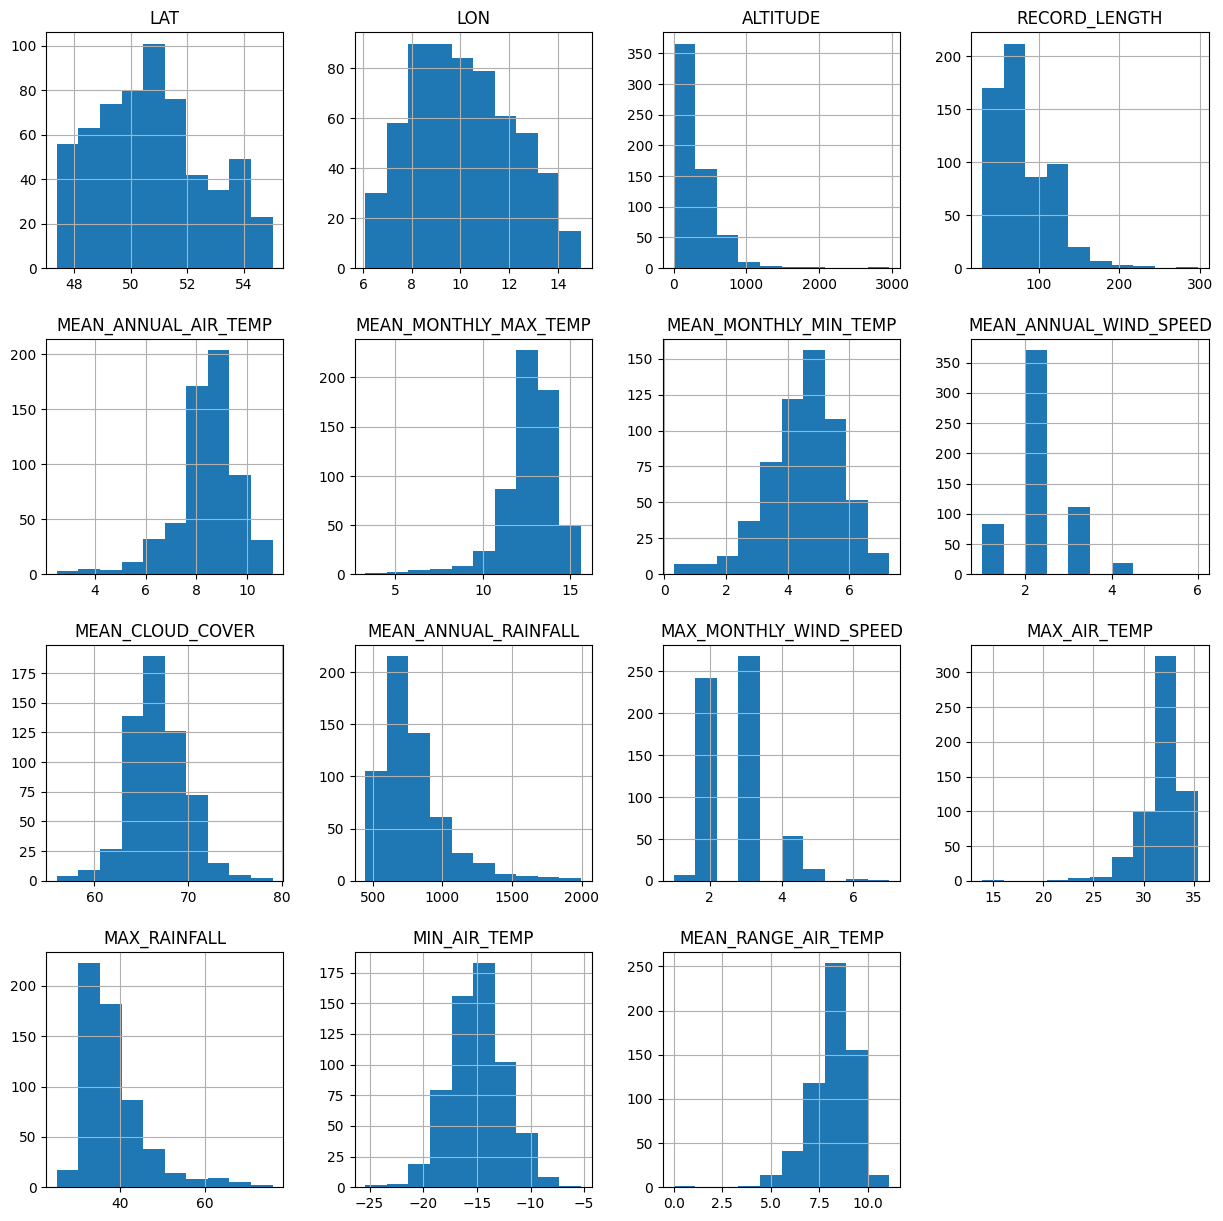

In [9]:
dwd.hist(figsize=(15,15))

# Imputar, strategy:Median

In [10]:
im = SimpleImputer(strategy='median')
im.fit(dwd)

SimpleImputer(strategy='median')

In [11]:
Xi = pd.DataFrame(im.transform(dwd),columns=dwd.columns) #imputa valores vacíos con mediana

In [12]:
Xi.describe()

,LAT,LON,ALTITUDE,RECORD_LENGTH,MEAN_ANNUAL_AIR_TEMP,MEAN_MONTHLY_MAX_TEMP,MEAN_MONTHLY_MIN_TEMP,MEAN_ANNUAL_WIND_SPEED,MEAN_CLOUD_COVER,MEAN_ANNUAL_RAINFALL,MAX_MONTHLY_WIND_SPEED,MAX_AIR_TEMP,MAX_RAINFALL,MIN_AIR_TEMP,MEAN_RANGE_AIR_TEMP
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,50.748483,10.119593,285.283806,80.073456,8.401503,12.656761,4.488815,2.121870,66.806344,786.166110,2.726210,31.840401,38.494157,-14.932888,8.168280
std,1.898860,2.054339,283.779402,36.821152,1.226497,1.492081,1.180793,0.694103,3.035888,231.319216,0.785635,2.007345,7.280079,2.570010,1.165744
min,47.398600,6.094100,1.000000,30.000000,2.500000,3.300000,0.300000,1.000000,56.000000,446.000000,1.000000,13.900000,25.000000,-25.400000,0.000000
25%,49.271750,8.477350,75.000000,54.000000,8.000000,12.100000,3.800000,2.000000,65.000000,642.000000,2.000000,31.100000,34.000000,-16.700000,7.600000
50%,50.639000,9.966200,224.000000,70.000000,8.500000,12.900000,4.600000,2.000000,67.000000,737.500000,3.000000,32.200000,36.000000,-14.900000,8.400000
75%,51.956800,11.702800,418.000000,103.000000,9.100000,13.500000,5.300000,2.000000,68.000000,854.000000,3.000000,33.100000,41.000000,-13.300000,8.900000
max,55.011000,14.950600,2964.000000,297.000000,11.000000,15.600000,7.300000,6.000000,79.000000,1995.000000,7.000000,35.400000,76.000000,-5.300000,11.100000


In [13]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],dwd[v].dropna()).statistic),dwd.columns),columns=['var','ks']).sort_values('ks',ascending=False) #prueba Kolmogorov-Smirnof para determinar si mantiene la distribución
#ks

In [14]:
out = ks[ks['ks']>0.1]['var'].tolist() #variables que deben salir
var = [v for v in Xi.columns if v not in out] # variables que deben permanecer
Xi.drop(out,axis=1,inplace=True)

# OutLayers

array([[<Axes: title={'center': 'RECORD_LENGTH'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_AIR_TEMP'}>],
       [<Axes: title={'center': 'MEAN_MONTHLY_MAX_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MIN_TEMP'}>]], dtype=object)

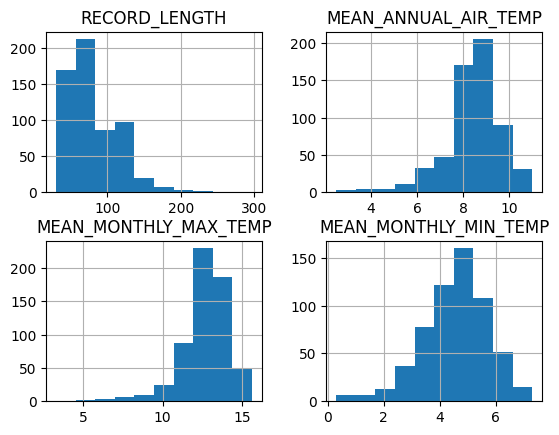

In [15]:
Xi.hist(['RECORD_LENGTH', 'MEAN_ANNUAL_AIR_TEMP',
       'MEAN_MONTHLY_MAX_TEMP', 'MEAN_MONTHLY_MIN_TEMP'])

In [16]:
Xi.describe().T[['50%','75%']].reset_index().values

array([['LAT', 50.639, 51.9568],
       ['LON', 9.9662, 11.7028],
       ['ALTITUDE', 224.0, 418.0],
       ['RECORD_LENGTH', 70.0, 103.0],
       ['MEAN_ANNUAL_AIR_TEMP', 8.5, 9.1],
       ['MEAN_MONTHLY_MAX_TEMP', 12.9, 13.5],
       ['MEAN_MONTHLY_MIN_TEMP', 4.6, 5.3],
       ['MEAN_ANNUAL_WIND_SPEED', 2.0, 2.0],
       ['MEAN_CLOUD_COVER', 67.0, 68.0],
       ['MEAN_ANNUAL_RAINFALL', 737.5, 854.0],
       ['MAX_MONTHLY_WIND_SPEED', 3.0, 3.0],
       ['MAX_AIR_TEMP', 32.2, 33.1],
       ['MAX_RAINFALL', 36.0, 41.0],
       ['MIN_AIR_TEMP', -14.9, -13.3],
       ['MEAN_RANGE_AIR_TEMP', 8.4, 8.9]], dtype=object)

In [17]:
for v,li,ls in Xi.describe(percentiles=[0.02,0.98]).T[['2%','98%']].reset_index().values: # v es la columna, li limite inferior, ls limite superior
    Xi[f'extreme_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int) # etiqueta con unos las observaciones que se consideran extremos y 0's las que no

In [18]:
Xi.filter(like="extreme", axis=1).sum() # cuenta los valores extremos por columna

,0
extreme_LAT,24
extreme_LON,24
extreme_ALTITUDE,24
extreme_RECORD_LENGTH,22
extreme_MEAN_ANNUAL_AIR_TEMP,22
extreme_MEAN_MONTHLY_MAX_TEMP,23
extreme_MEAN_MONTHLY_MIN_TEMP,20
extreme_MEAN_ANNUAL_WIND_SPEED,2
extreme_MEAN_CLOUD_COVER,15
extreme_MEAN_ANNUAL_RAINFALL,23


In [19]:
Xi['ex_'] = Xi.filter(like='extreme').max(axis=1) #etiqueta registros con un outlayer en al menos una columna
Xi=Xi.drop(Xi.filter(like='extreme_', axis=1).columns, axis=1) #elimina las columnas empleadas previamente (valor extremo por columna)

In [20]:
Xi['ex_'].value_counts(normalize=True) # pérdida de observaciones 26%

,proportion
ex_,
0,0.732888
1,0.267112


In [21]:
Xi = Xi[Xi['ex_']==0].reset_index(drop=True).drop(Xi.filter(like='ex_'),axis=1)# se eliminan outlayers, se resetea el index y elimina columna auxiliar de extremos

array([[<Axes: title={'center': 'RECORD_LENGTH'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_AIR_TEMP'}>],
       [<Axes: title={'center': 'MEAN_MONTHLY_MAX_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MIN_TEMP'}>]], dtype=object)

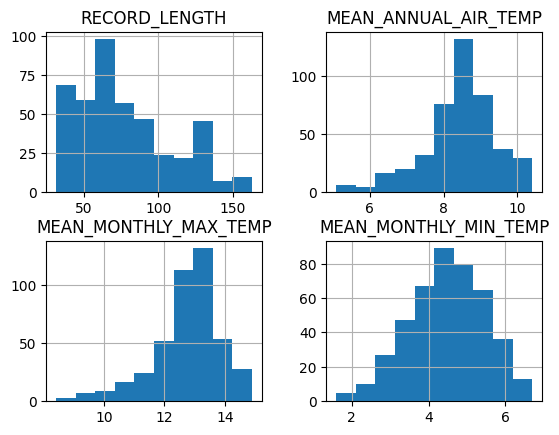

In [22]:
Xi.hist(['RECORD_LENGTH', 'MEAN_ANNUAL_AIR_TEMP',
       'MEAN_MONTHLY_MAX_TEMP', 'MEAN_MONTHLY_MIN_TEMP'])

# Preprocessing: Data Scaling

In [23]:
scaler = StandardScaler()
X_scaled=scaler.fit_transform(Xi)
#X_train = scaler.fit_transform(X_train)

In [24]:
#y_train = scaler.fit_transform(pd.DataFrame(data=y_train))

In [25]:
pd.DataFrame(X_scaled, columns=Xi.columns)

,LAT,LON,ALTITUDE,RECORD_LENGTH,MEAN_ANNUAL_AIR_TEMP,MEAN_MONTHLY_MAX_TEMP,MEAN_MONTHLY_MIN_TEMP,MEAN_ANNUAL_WIND_SPEED,MEAN_CLOUD_COVER,MEAN_ANNUAL_RAINFALL,MAX_MONTHLY_WIND_SPEED,MAX_AIR_TEMP,MAX_RAINFALL,MIN_AIR_TEMP,MEAN_RANGE_AIR_TEMP
0,-1.623516,-0.653430,0.966807,-0.724339,-0.254457,0.308714,-0.996342,-0.105449,0.030116,-0.064647,-1.020329,0.318709,0.210200,-0.551206,1.437678
1,1.267269,-0.982202,-1.083297,-1.035540,0.776998,0.397467,0.964141,-0.105449,0.030116,-0.041524,0.529583,0.244681,-1.051409,1.153848,-0.522048
2,-1.183784,1.602448,0.314930,-0.444258,-0.048166,0.574972,-0.583609,-1.819979,-0.704370,0.137675,-1.020329,0.688849,0.931119,-1.887600,1.328804
3,1.012831,-1.156388,-0.984098,-0.724339,0.880144,0.574972,0.757774,-0.105449,0.030116,0.160797,-1.020329,0.096624,-0.871179,0.831270,-0.086553
4,0.024655,-0.387265,0.125981,-1.253380,-0.254457,-0.046297,-0.377242,1.609080,1.866331,-0.631147,0.529583,-0.347544,-0.150260,-0.044298,0.348941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,1.279020,-1.474798,-1.253351,-0.662099,0.880144,0.397467,1.067324,-0.105449,0.397359,0.114552,0.529583,0.022596,-0.690949,1.338178,-0.630922
435,-1.553009,-0.207172,1.377772,-0.755459,-0.667039,-0.401308,-0.789975,-0.105449,1.131845,0.629027,0.529583,-0.717685,0.750889,-1.104197,0.348941
436,1.385859,1.592407,-0.998269,-1.284500,-0.254457,-0.312555,-0.067692,-0.105449,0.397359,-1.151403,-1.020329,-0.051432,-0.690949,0.093950,-0.304301
437,-0.312609,-1.886637,1.212441,-0.973300,-1.182767,-1.466341,-0.480425,-0.105449,2.233574,1.334262,0.529583,-1.754079,0.029970,0.831270,-1.284164


# Preparing training set and test set

In [26]:
X=Xi.drop('MEAN_ANNUAL_RAINFALL', axis=1)
y=Xi['MEAN_ANNUAL_RAINFALL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((351, 14), (88, 14))

In [27]:
columns=dict(zip(Xi.columns, range(len(Xi))))

In [28]:
X=np.delete(X_scaled.T,columns['MEAN_ANNUAL_RAINFALL'],0).T
y=X_scaled.T[9]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((351, 14), (88, 14))

In [30]:
#plt.hist(y_train)
#plt.hist(scaler.transform(pd.DataFrame(data=y_train)))

# OLS model

## Backward Selection

In [ ]:
#from sklearn.metrics import mean_squared_error

In [ ]:
#MSE=make_scorer(make_scorer)

In [31]:
#Secuential forward selection
sfs = SFS(
    LinearRegression(), # Use LinearRegression as the estimator
    k_features=5,
    forward=True,
    scoring='r2', # Use the make_scorer object
    cv=2)
# You can access the results after fitting
# results = sfs.transform(X_train)
# print(results)

In [32]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=2, estimator=LinearRegression(), k_features=(5, 5),
                          scoring='r2')

In [41]:
sfs.get_metric_dict()

{1: {'feature_idx': (11,),
  'cv_scores': array([0.61300533, 0.67723707]),
  'avg_score': np.float64(0.6451211960990727),
  'feature_names': ('11',),
  'ci_bound': np.float64(0.1381834317008888),
  'std_dev': np.float64(0.03211586906541897),
  'std_err': np.float64(0.03211586906541897)},
 2: {'feature_idx': (1, 11),
  'cv_scores': array([0.70994468, 0.76069785]),
  'avg_score': np.float64(0.73532126465979),
  'feature_names': ('1', '11'),
  'ci_bound': np.float64(0.10918664429309805),
  'std_dev': np.float64(0.025376587689615593),
  'std_err': np.float64(0.025376587689615593)},
 3: {'feature_idx': (1, 10, 11),
  'cv_scores': array([0.74023206, 0.81300653]),
  'avg_score': np.float64(0.7766192974815789),
  'feature_names': ('1', '10', '11'),
  'ci_bound': np.float64(0.1565616296095562),
  'std_dev': np.float64(0.03638723351503498),
  'std_err': np.float64(0.03638723351503498)},
 4: {'feature_idx': (1, 9, 10, 11),
  'cv_scores': array([0.74360443, 0.81642256]),
  'avg_score': np.float64(

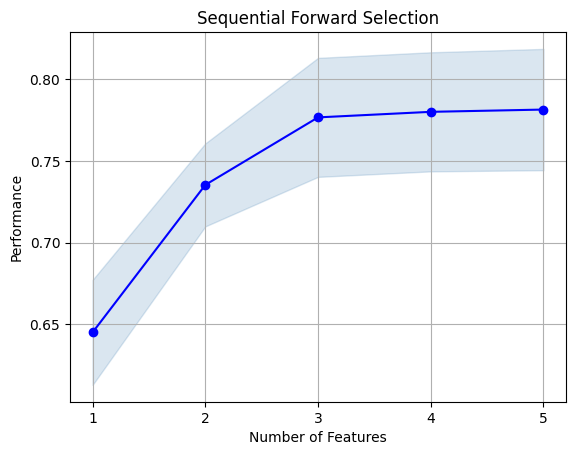

In [33]:
fig1 = plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [34]:
selectedVars= np.array(sfs.get_metric_dict()[5]['feature_names']).astype(int)
#selectedVars

In [35]:
X_train_selected=X_train[:,selectedVars]
X_test_selected=X_test[:,selectedVars]

##Model

In [ ]:
#X_train2=sm.add_constant(X_train.transpose()[selectedVars].transpose())

In [36]:
model=sm.OLS(y_train, X_train_selected)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.790
Model:                            OLS   Adj. R-squared (uncentered):              0.787
Method:                 Least Squares   F-statistic:                              260.8
Date:                Fri, 15 Aug 2025   Prob (F-statistic):                   5.19e-115
Time:                        00:04:07   Log-Likelihood:                         -230.42
No. Observations:                 351   AIC:                                      470.8
Df Residuals:                     346   BIC:                                      490.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2785      0.026    -10.812      0.000      -0.329      -0.228
x2            -0.0481      0.025     -1.896      0.059      -0.098       0.002
x3            -0.0697      0.028     -2.500      0.013      -0.124      -0.015
x4            -0.2476      0.029     -8.652      0.000      -0.304      -0.191
x5             0.7253      0.027     26.658      0.000       0.672       0.779
==============================================================================
Omnibus:                        7.531   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.624
Skew:                          -0.295   Prob(JB):                       0.0221
Kurtosis:                       3.417   Cond. No.                         1.83
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



1.   Adjusted R^2 introduce a penalization to R^2 which is the proportion of total variation about the mean Y explained by the regression
2.   F-test: Null hypotesis: variance of SS due to regression and variance of SS about regression are equal.
The model is usefull when MSR is greater than MSE.
3. T-test: Null hypotesis: Coef of an predictor is 0.
The estimator (estimate of thing-test value of thing)/standard error of estimate thing, follows a T distribution.



Variable X2 dont pass the t-tes for 95% of signicance

Text(0.5, 1.0, 'Residual Plot')

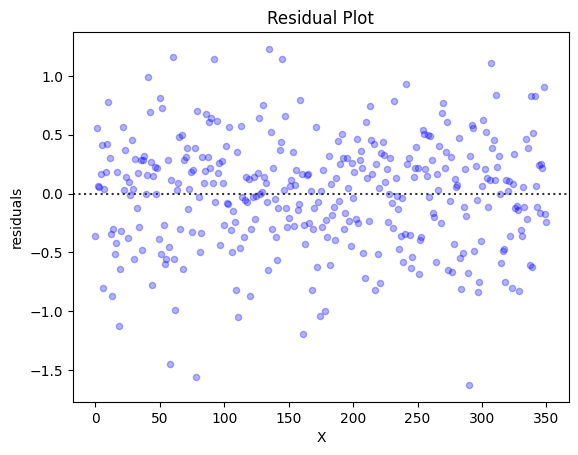

In [39]:
resid_df = pd.DataFrame({'X': range(len(results.resid)), 'residuals': results.resid})
sns.residplot(x="X", y="residuals", data=resid_df, scatter_kws={"s": 20, "color":'blue', "alpha":0.3}).set_title('Residual Plot')


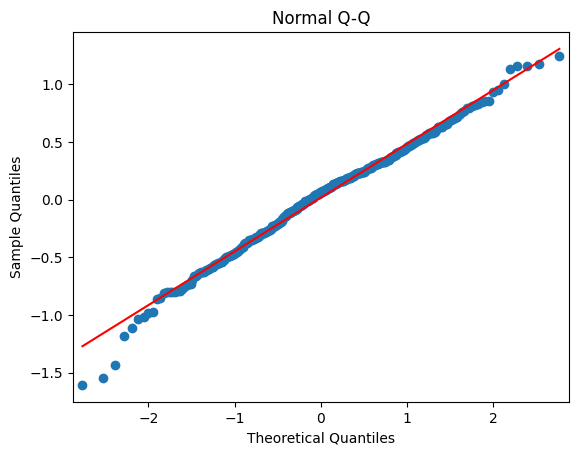

In [40]:
sm.qqplot(results.resid, line='s')
plt.title('Normal Q-Q')
plt.show()

In [69]:
data_value=np.append(np.zeros(len(y_test)),np.ones(len(pred)))

In [70]:
pred_test=np.append(y_test,pred)
pred=results.predict(X_test_selected)

In [72]:
pred_df=pd.DataFrame({'value': pred_test, 'data': data_value})
pred_df

,value,data
0,0.368899,0.0
1,-0.371019,0.0
2,-1.151403,0.0
3,0.455609,0.0
4,-0.498193,0.0
...,...,...
171,-0.484928,1.0
172,0.038351,1.0
173,1.060441,1.0
174,0.643791,1.0


In [75]:
pred_df.reset_index(drop=False, inplace=True)

In [78]:
pre_df

,X,value,data
0,0,0.790779,0.421879
1,1,-0.173039,0.197981
2,2,-0.014002,1.137400
3,3,1.577759,1.122150
4,4,-0.412593,0.085600
...,...,...,...
83,83,-0.484928,-0.437623
84,84,0.038351,1.218657
85,85,1.060441,-0.025255
86,86,0.643791,1.199790


<Axes: ylabel='value'>

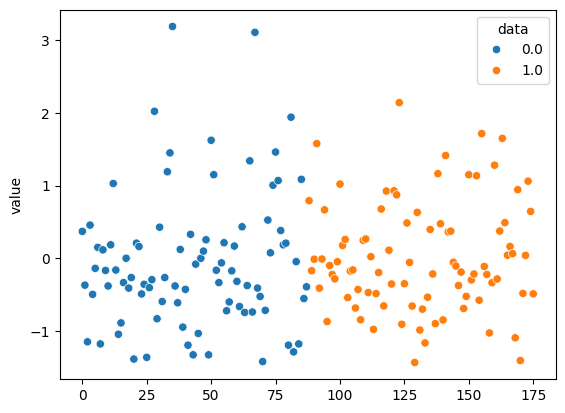

In [79]:
sns.scatterplot(data=pred_df, x=range(len(pred)+len(y_test)), y="value", hue="data")

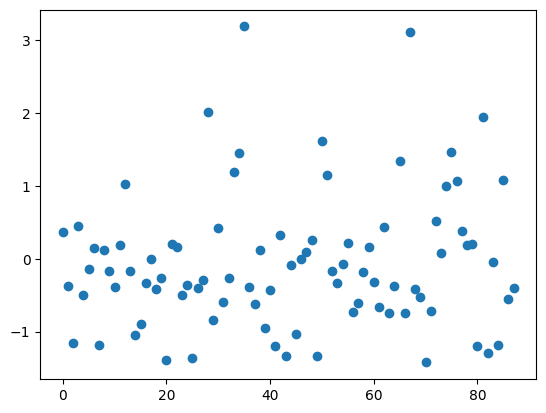

In [51]:
plt.scatter(range(len(pred)),y_test)

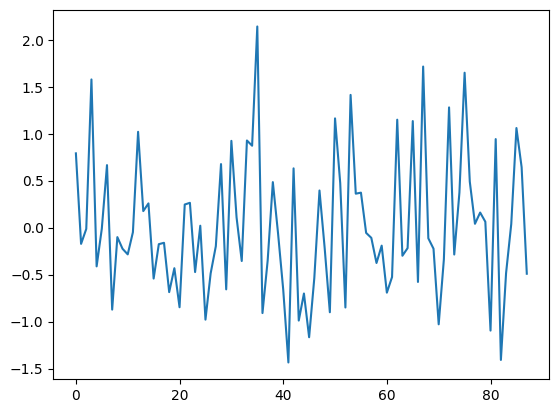

In [ ]:
#X_test2=X_test.rename(columns=dict(zip(X_test.columns, range(len(X_test.columns)))))

In [ ]:
def model_rmse(model_results):
    return np.sqrt(model_results.mse_resid)

In [ ]:
def diff_rmse(obs, preds):
    return np.sqrt(np.sum((obs-preds)**2)/len(obs))

In [ ]:
model_rmse(results)

np.float64(81.33590100252405)

In [ ]:
diff_rmse(y_test,Test.predicted)

np.float64(757.9815665343201)

In [ ]:
sm.tools.eval_measures.aic(results.llf, X_train2.shape[0], X_train2.shape[1])

np.float64(4089.85140534379)

In [ ]:
X_test2=sm.add_constant(X_test2.filter(items=selectedVars, axis=1))

In [ ]:
test=results.get_prediction(exog=X_test2)

In [ ]:
test.predicted

array([15.73408785, 13.89127833, 14.73643293, 21.14366068, 12.93909425,
       16.82010751, 16.63395624, 13.31605259, 12.97699346, 10.48001628,
       13.05577037, 12.87514826, 18.28415102, 14.04283858, 16.60459055,
       13.01495552, 11.03187001, 11.41909107,  9.01974547, 12.81808084,
        7.56385826, 14.49759421, 16.62098347,  7.76528226, 13.93367354,
        6.07772254, 11.96433749, 12.11065523, 15.64989443, 12.09167152,
       18.66575731, 14.78917489, 11.38334139, 19.15289017, 21.08498915,
       21.46856768,  7.57009669, 13.13734284, 15.30327919, 14.24132645,
       12.22242312,  5.27449594, 17.38259898, 12.27863775, 11.46740321,
        9.81686751, 11.11745887, 14.64961677, 10.58728466,  9.51612863,
       21.33872641, 13.12794077, 12.559705  , 22.24952988, 16.31017253,
       15.28620492, 14.02410919, 13.25821215,  9.97969606, 14.3413384 ,
       12.28155445, 14.3024521 , 17.26372713, 16.25980106, 13.35041957,
       21.0020857 , 12.67401671, 24.90491832, 13.3579023 , 13.53

In [ ]:
Test.aic

AttributeError: 'PredictionResults' object has no attribute 'aic'

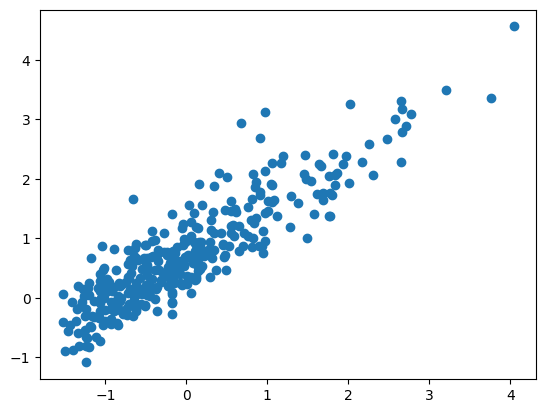

In [ ]:
plt.scatter(y_train, results.predict(X_train2))

In [ ]:
results.predict(sm.add_constant(X_test2))

ValueError: shapes (88,15) and (6,) not aligned: 15 (dim 1) != 6 (dim 0)

In [ ]:
np.array(results.params)

array([-7.97972799e-17, -2.73267598e-01, -4.66283116e-02, -6.92826394e-02,
       -2.48196216e-01,  7.37587148e-01])

In [ ]:
y_train.shape

(351, 1)

In [ ]:
scaler.inverse_transform(np.array(results.params).reshape(1, -1))

array([[768.8034188 , 720.64726826, 760.5864183 , 756.59419518,
        725.06543298, 898.78354805]])

In [ ]:
model=sm.OLS(scaler.inverse_transform(y_train), scaler.inverse_transform(X_train2))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     260.5
Date:                Thu, 07 Aug 2025   Prob (F-statistic):          8.87e-115
Time:                        17:59:38   Log-Likelihood:                -2038.9
No. Observations:                 351   AIC:                             4090.
Df Residuals:                     345   BIC:                             4113.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7320      0.056     13.107      0.000       0.622       0.842
x2            -0.2733      0.025    -10.819      0.000      -0.323      -0.224
x3            -0.0466      0.025     -1.879      0.061      -0.095       0.002
x4            -0.0693      0.028     -2.507      0.013      -0.124      -0.015
x5            -0.2482      0.029     -8.623      0.000      -0.305      -0.192
x6             0.7376      0.028     26.649      0.000       0.683       0.792
==============================================================================
Omnibus:                        7.492   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.574
Skew:                          -0.294   Prob(JB):                       0.0227
Kurtosis:                       3.415   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
results.predict(X_test2[selectedVars])

ValueError: shapes (88,5) and (6,) not aligned: 5 (dim 1) != 6 (dim 0)

array([[-1.45510872,  0.75048216,  1.11425374, ...,  1.77465717,
        -1.06866465,  0.56854202],
       [-0.72863276,  1.25345691,  1.48930373, ..., -0.48791915,
        -0.97350958,  0.02861169],
       [-0.9231903 , -1.13571353, -0.10350119, ..., -0.13983049,
         1.92872011, -0.18736044],
       ...,
       [-0.74560228, -1.75836474, -0.23777835, ...,  0.20825818,
         0.73928171,  0.89250022],
       [-1.56673548, -0.22969171,  1.34576608, ...,  0.73039117,
        -1.11624219,  0.35256989],
       [-0.02279082,  0.40377559,  1.12814448, ..., -0.13983049,
        -0.59288929, -0.9432629 ]])

In [ ]:
results.predict(X_test2)

NameError: name 'test_set' is not defined

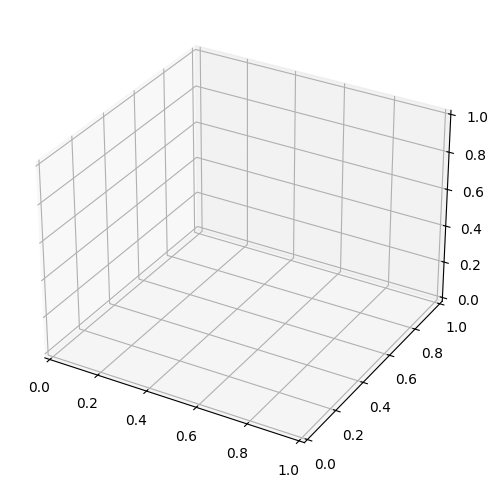

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter3D(
    test_set["ALTITUDE"].values,
    test_set["MAX_RAINFALL"].values,
    test_set["MEAN_ANNUAL_RAINFALL"].values,
)
ax.set_xlabel("ALTITUDE")
ax.set_ylabel("MAX_RAINFALL")
ax.set_zlabel("MEAN_ANNUAL_RAINFALL")
plt.show()

In [ ]:
def remove_feature(ds, current_features, dependent_var, scoring):
    results = {'predictor': [], 'aic': [], 'bic': []}
    for col in current_features:
        # Build our formula string by joining the list current_features and removing one
        remaining_features = current_features.copy()
        remaining_features.remove(col)
        formula = f"{dependent_var} ~ {' + '.join(remaining_features)}"
        model = sm.OLS.from_formula(formula, data=ds).fit()
        results['predictor'].append(col)
        results["aic"].append(model.aic)
        results["bic"].append(model.bic)
    return pd.DataFrame(results).sort_values(by=[scoring], ascending=True)

def backward_selector(ds, dependent_var, scoring):
    # A dict to store the final results
    results = {'predictor': [], 'aic': [], 'bic': []}
    # The same to store the first iteration
    scoring_dict = {'predictor': [], 'aic': [], 'bic': []}
    current_features = ds.columns.drop(dependent_var).tolist()
    formula = f"{dependent_var} ~ {' + '.join(current_features)}"
    model = sm.OLS.from_formula(formula, data=ds).fit()
    # Append the results of the first iteration
    scoring_dict["predictor"].extend(current_features)
    scoring_dict['aic'].extend([model.aic] * len(current_features))
    scoring_dict['bic'].extend([model.bic] * len(current_features))
    # Transform scoring to table
    scoring_table = pd.DataFrame(scoring_dict).sort_values(by=[scoring], ascending=True)
    prev_score = scoring_table[scoring].min()
    while len(current_features) > 1:


        # Remove a feature
        scoring_table = remove_feature(ds, current_features, dependent_var, scoring)
        # Stop if the scoring is worse
        if prev_score < scoring_table[scoring].min():
          break
        # Remove the predictor with the highest score
        current_features.remove(scoring_table.loc[0, 'predictor'])
        formula = f"{dependent_var} ~ {' + '.join(current_features)}"
        prev_score = scoring_table[scoring].min()
        results['predictor'].append(scoring_table.loc[0, 'predictor'])
        results['aic'].append(scoring_table[scoring].min())
        results['bic'].append(scoring_table['bic'].min())
    return pd.DataFrame(results), formula



In [ ]:
# Assuming you have the 'train' DataFrame and the 'MEAN_ANNUAL_RAINFALL' column
results, formula= backward_selector(train_set, 'MEAN_ANNUAL_RAINFALL', 'aic')
print("Final formula: " + formula)
results

Final formula: MEAN_ANNUAL_RAINFALL ~ LON + ALTITUDE + RECORD_LENGTH + MEAN_ANNUAL_AIR_TEMP + MEAN_MONTHLY_MAX_TEMP + MEAN_MONTHLY_MIN_TEMP + MEAN_ANNUAL_WIND_SPEED + MEAN_CLOUD_COVER + MAX_MONTHLY_WIND_SPEED + MAX_AIR_TEMP + MAX_RAINFALL + MIN_AIR_TEMP + MEAN_RANGE_AIR_TEMP


,predictor,aic,bic
0,LAT,4096.984863,4151.03587


In [ ]:
remove_feature(train_set, ['ALTITUDE', 'MAX_RAINFALL'], 'MEAN_ANNUAL_RAINFALL', 'aic')

,predictor,aic,bic
1,MAX_RAINFALL,4476.290888,4484.012461
0,ALTITUDE,4245.965298,4253.686870


In [ ]:
def model_rmse(model_results):
    return np.sqrt(model_results.mse_resid)

In [ ]:
def diff_rmse(obs, preds):
    return np.sqrt(np.sum((obs-preds)**2)/len(obs))

Simple: Altitude

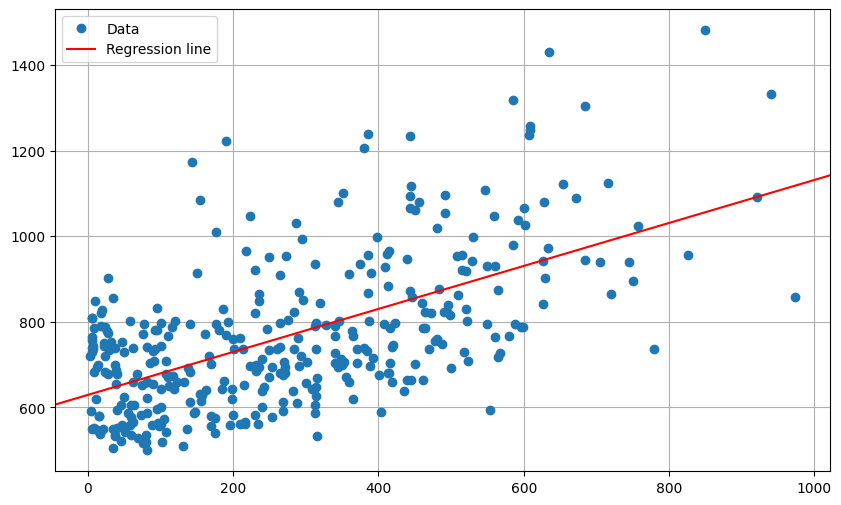

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_set["ALTITUDE"], train_set["MEAN_ANNUAL_RAINFALL"], "o", label="Data")
abline_plot(model_results=results, ax=ax, color="red", label="Regression line")
ax.grid()
ax.legend(loc="best")

In [ ]:
pred = results.predict(test_set)

test_rmse = diff_rmse(test_set["MEAN_ANNUAL_RAINFALL"], pred)
print("RMSE on test set:", test_rmse)
model_outcome = {}
model_outcome["simple_alt"] = {
    "model": simple_alt_model,
    "results": results,
    "rmse": pd.DataFrame.from_dict({"name": pd.Index(["simple alt model"]), "train_RMSE": model_rmse(results), "test_RMSE": test_rmse})
}

RMSE on test set: 143.1685655063734


Simple Max rainFall model

In [ ]:
pred = results.predict(test_set)

test_rmse = diff_rmse(test_set["MEAN_ANNUAL_RAINFALL"], pred)
print("RMSE on test set:", test_rmse)
model_outcome["simple_meanAnnTemp"] = {
    "model": simple_maxRainFall,
    "results": results,
    "rmse": pd.DataFrame.from_dict({"name": pd.Index(["simple meanAnnTemp model"]), "train_RMSE": model_rmse(results), "test_RMSE": test_rmse})
}

RMSE on test set: 125.75832810318703


In [ ]:
multi_alt_rain_model = smf.ols(formula='MEAN_ANNUAL_RAINFALL ~ ALTITUDE + MAX_RAINFALL', data=train_set)
results = multi_alt_rain_model.fit()

pred = results.predict(test_set)

test_rmse = diff_rmse(test_set["MEAN_ANNUAL_RAINFALL"], pred)
print("RMSE on test set:", test_rmse)

model_outcome["multi_alt_rain"] = {
    "model": multi_alt_rain_model,
    "results": results,
    "rmse": pd.DataFrame.from_dict({"name": pd.Index(["multi alt rain model"]), "train_RMSE": model_rmse(results), "test_RMSE": test_rmse})
}

RMSE on test set: 124.82153877358358


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     MEAN_ANNUAL_RAINFALL   R-squared:                       0.673
Model:                              OLS   Adj. R-squared:                  0.672
Method:                   Least Squares   F-statistic:                     358.9
Date:                  Thu, 17 Oct 2024   Prob (F-statistic):           2.65e-85
Time:                          19:20:39   Log-Likelihood:                -2116.9
No. Observations:                   351   AIC:                             4240.
Df Residuals:                       348   BIC:                             4251.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -134.7240     42.487     -3.171      0.002    -218.288     -51.160
ALTITUDE         0.0970      0.034      2.863      0.004       0.030       0.164
MAX_RAINFALL    23.1354      1.257     18.400      0.000      20.662      25.608
==============================================================================
Omnibus:                        1.965   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.835
Skew:                           0.176   Prob(JB):                        0.400
Kurtosis:                       3.033   Cond. No.                     2.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
rmses = pd.concat([model_outcome["simple_alt"]["rmse"],model_outcome["simple_meanAnnTemp"]["rmse"],model_outcome["multi_alt_rain"]["rmse"]])

In [ ]:
#rmses = pd.concat([rmses, model_outcome["multi_alt_rain"]["rmse"]])
rmses

,name,train_RMSE,test_RMSE
0,simple alt model,141.840524,143.168566
0,simple meanAnnTemp model,102.166540,125.758328
0,multi alt rain model,101.129135,124.821539


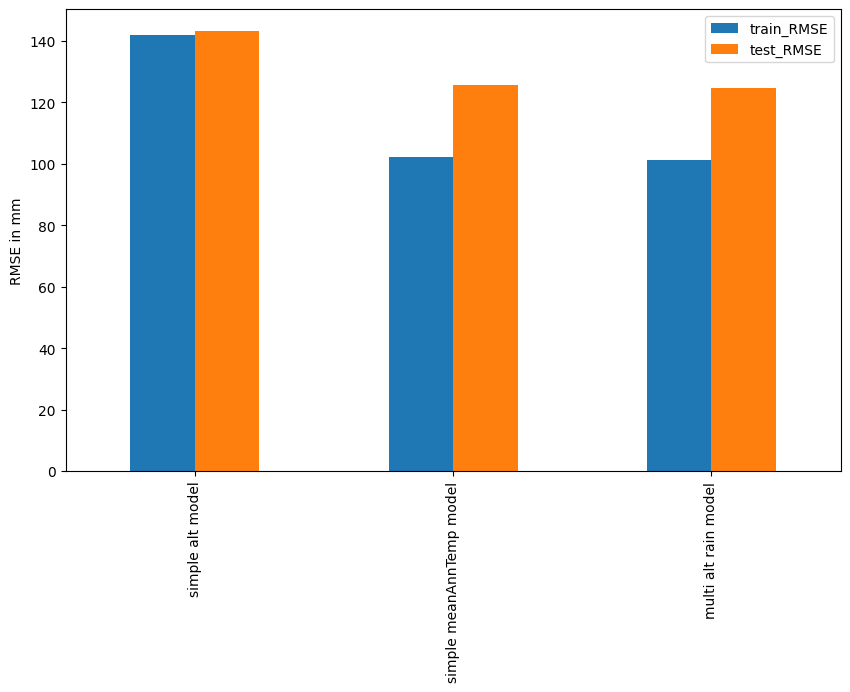

In [ ]:
_, ax = plt.subplots(figsize=(10,6))
rmses.plot(kind="bar", x="name", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE in mm")
plt.show()

In [ ]:
n_observations = X_train.shape[0]
#n_features = X_train.shape[1]
def adjusted_r(y_true, y_pred,n_features):
    score = 1 - (1 - r2_score(y_true,y_pred)) * ((n_observations - 1) / (n_observations - n_features - 1))
    return float(score)

adjusted_r_scorer = make_scorer(adjusted_r, greater_is_better=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = sns.load_dataset("iris")

# Create a seaborn plot
ax = sns.scatterplot(x="sepal_length", y="sepal_width", data=data)

# Adjust the y-axis limits
ax.set_ylim(1, 5)

# Or using plt
# plt.ylim(1, 5)

plt.show()

In [ ]:
X_test2 = X_test.rename(columns=dict(zip(X_test.columns, selectedVars)))
display(X_test2.head())